In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import lag_plot
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings

warnings.filterwarnings("ignore")

In [2]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./Sourcecode/bitcoin_df.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-06-22,64113.863281,64475.468750,63929.757812,64252.578125,64252.578125,9858198793
2024-06-23,64248.964844,64491.703125,63180.796875,63180.796875,63180.796875,11170471802
2024-06-24,63173.351562,63292.527344,58601.699219,60277.414062,60277.414062,43152133651


## Stationary test 
If p-value <= 0.05, we can reject null hypothesis of data stationery

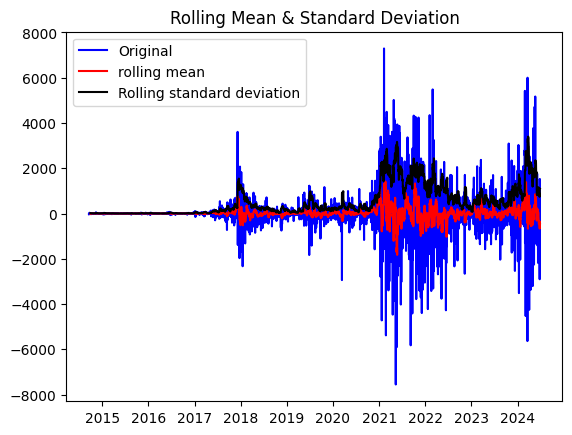

Results of Dickey-Fuller Test:
Test Statistic                -9.248909e+00
p-value                        1.510825e-15
#Lags Used                     2.700000e+01
Number of Observations Used    3.542000e+03
Critical value (1%)           -3.432198e+00
Critical value (5%)           -2.862356e+00
Critical value (10%)          -2.567205e+00
dtype: float64


In [4]:

def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim()
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
ts_log = data['Close']
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Bitcoin prediction in last 5 months

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=42896.735, Time=1.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60044.472, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56520.261, Time=0.94 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=42898.667, Time=2.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=42898.717, Time=1.63 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=53566.725, Time=4.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=42900.400, Time=2.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=42898.099, Time=1.69 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 15.812 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2663
Model:               SARIMAX(1, 0, 1)   Log Likelihood         

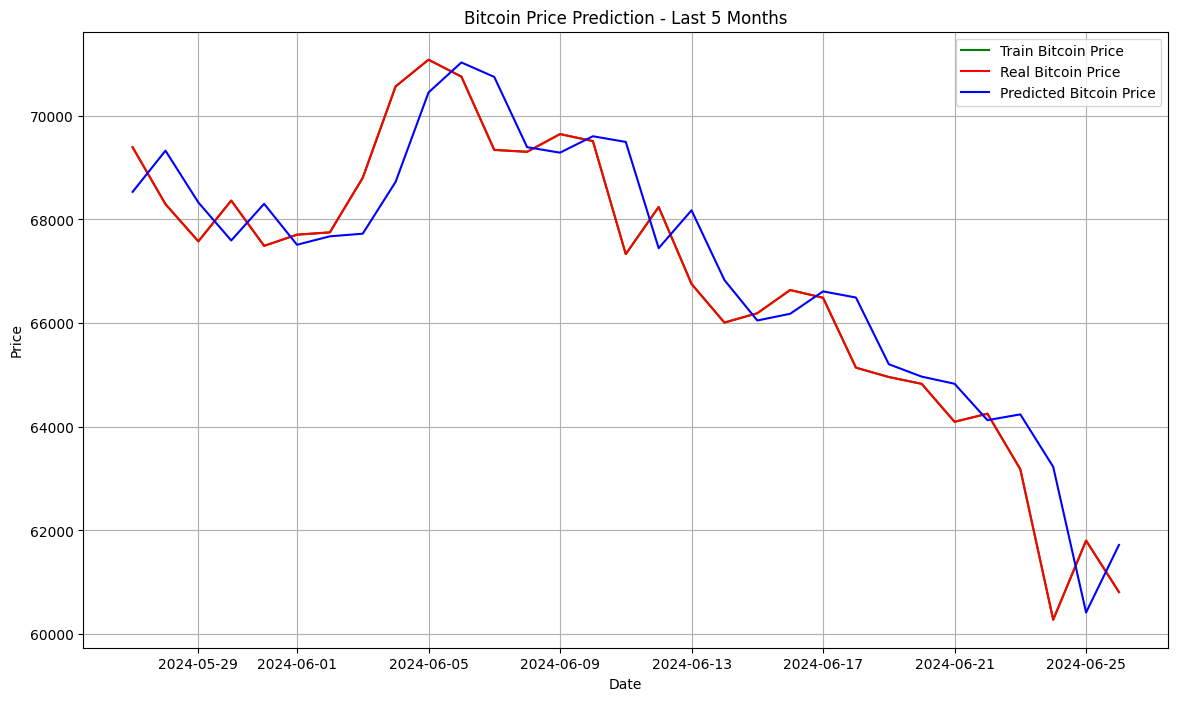

MSE: 1187316.8843136951
MAE: 682.0047615939745
RMSE: 1089.640713406807


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import pmdarima as pm  # Auto ARIMA
train_data = data.loc[:"2021-12-31"]
test_data = data.loc["2022-01-01":]

# Assuming train_data and test_data are your DataFrames and they have been defined
train_arma = train_data['Close']
test_arma = test_data['Close']
history = [x for x in train_arma]
y = test_arma
predictions = list()

# Use auto_arima to find the best ARIMA parameters
auto_model = pm.auto_arima(history,start_p = 1,start_q = 1,max_p=4,max_q=4,d=0,
                            seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(auto_model.summary())

# Initialize and fit the ARIMA model with optimized parameters
model = ARIMA(history, order=auto_model.order)
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

# Iterative forecasting
for i in range(1, len(y)):
    model = ARIMA(history, order=auto_model.order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)

end_date = test_data.index.max()

# Calculate the start date as 5 months before the end date
start_date = end_date - pd.DateOffset(days=30)

# Filter the data for the last 5 months
data_last_5_months = data[(data.index >= start_date) & (data.index <= end_date)]
test_data_last_5_months = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
predictions_last_5_months = predictions[-len(test_data_last_5_months):]
y_last_5_months = y[-len(test_data_last_5_months):]

# Plot the filtered data
plt.figure(figsize=(14, 8))
plt.plot(data_last_5_months.index, data_last_5_months['Close'], color='green', label='Train Bitcoin Price')
plt.plot(test_data_last_5_months.index, y_last_5_months, color='red', label='Real Bitcoin Price')
plt.plot(test_data_last_5_months.index, predictions_last_5_months, color='blue', label='Predicted Bitcoin Price')
plt.legend()
plt.grid(True)
plt.title('Bitcoin Price Prediction - Last 5 Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculating performance metrics
mse = mean_squared_error(y, predictions)
mae = mean_absolute_error(y, predictions)
rmse = sqrt(mse)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)


In [33]:
import yfinance as yf
ticker = 'BTC-USD'
data = yf.download(ticker, start="2014-06-01", end="2024-07-20")
# get data with Date > 2024-06-20
data = data[data.index > '2024-06-23']
data.sort_values('Date', ascending= False)
df_temp = data.copy()
#df_temp = df_temp[df_temp.index < '2024-06-26']
#chỉ giữ lại cột Date và Close, đổi tên cột Close thành Forecast
df_temp = df_temp[['Close']]
df_temp.columns = ['Forecast']
#data = data[data.index < '2024-06-28']

# Forecasting
forecast = model_fit.forecast(steps=2)
forecast = pd.DataFrame(forecast, columns=['Forecast'], index=pd.date_range(start=test_data.index.max(), periods=2))
# ghép forecast vào df_temp
df_temp = pd.concat([df_temp, forecast])

[*********************100%%**********************]  1 of 1 completed


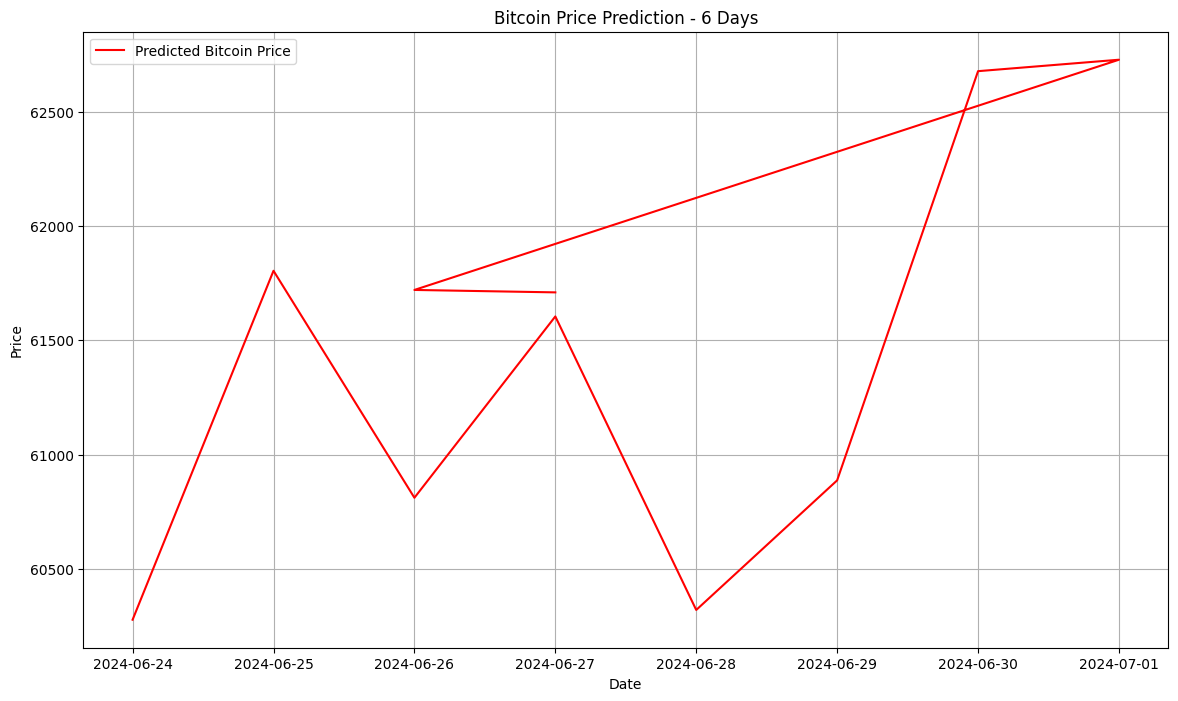

In [35]:
#trực quan hóa dữ liệu từ cột Forecast trên forecast df và cột Close trên data df
plt.figure(figsize=(14, 8))
#plt.plot(data['Close'], color='green', label='Train Bitcoin Price')
plt.plot(df_temp['Forecast'], color='red', label='Predicted Bitcoin Price')
plt.legend()
plt.grid(True)
plt.title('Bitcoin Price Prediction - 6 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

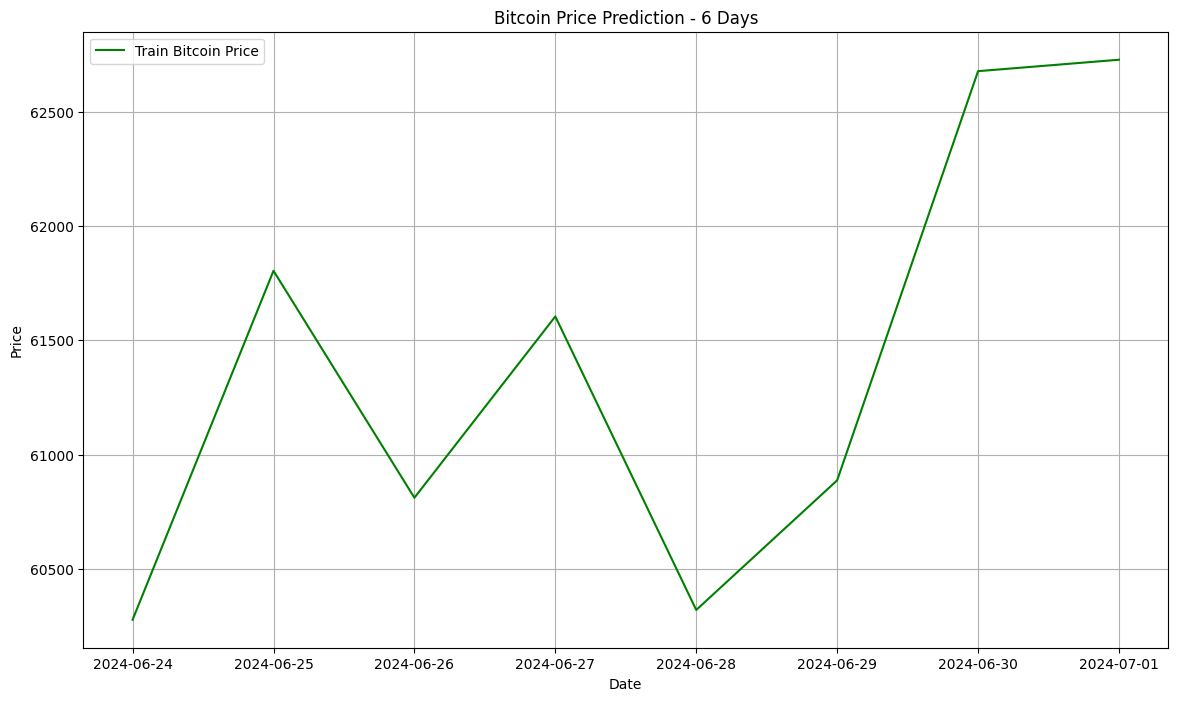

In [34]:
#trực quan hóa dữ liệu từ cột Forecast trên forecast df và cột Close trên data df
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], color='green', label='Train Bitcoin Price')
#plt.plot(df_temp['Forecast'], color='red', label='Predicted Bitcoin Price')
plt.legend()
plt.grid(True)
plt.title('Bitcoin Price Prediction - 6 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


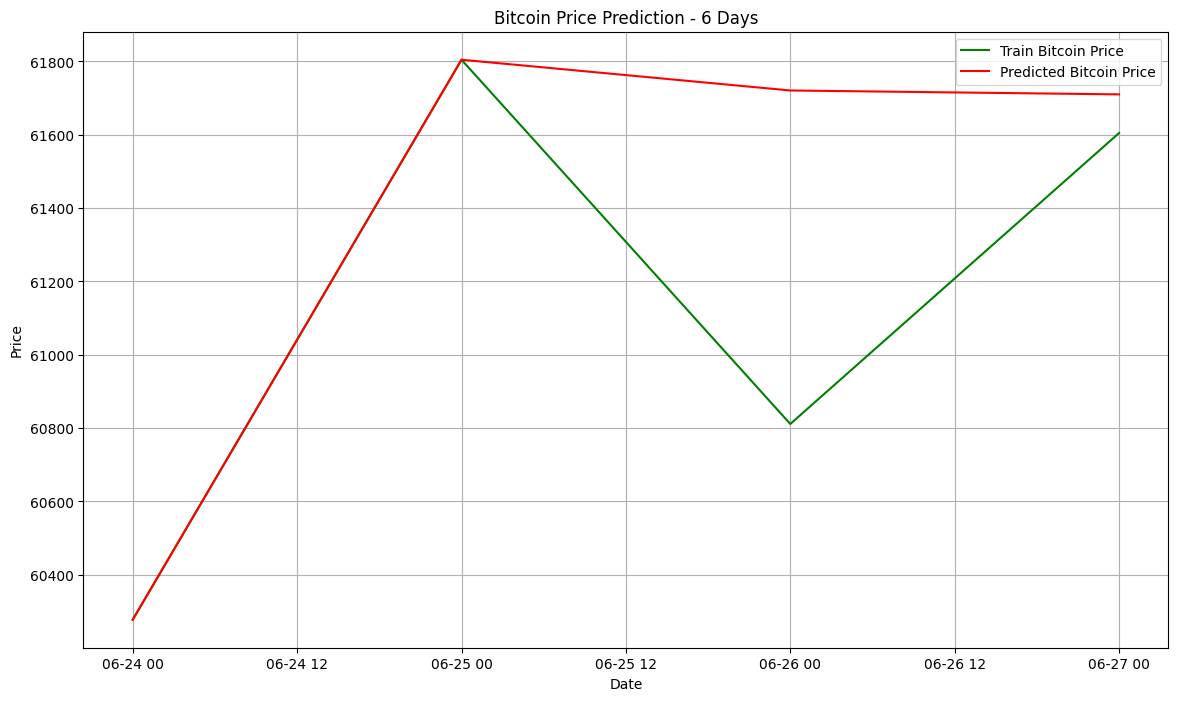

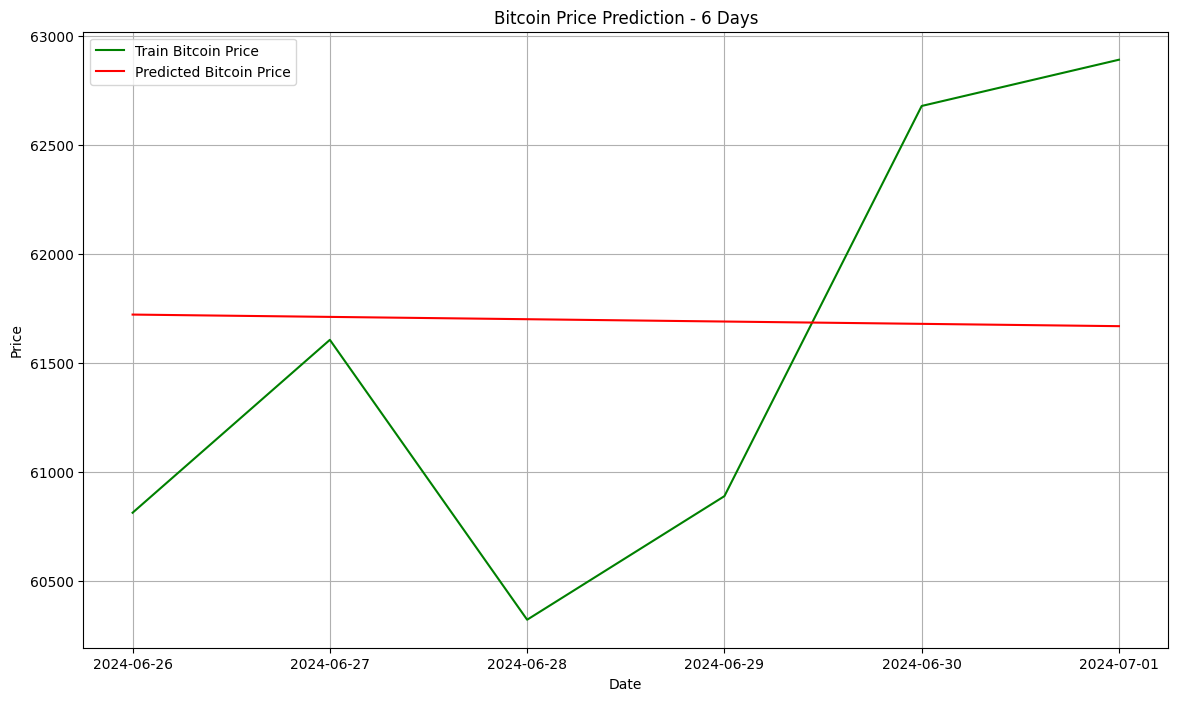